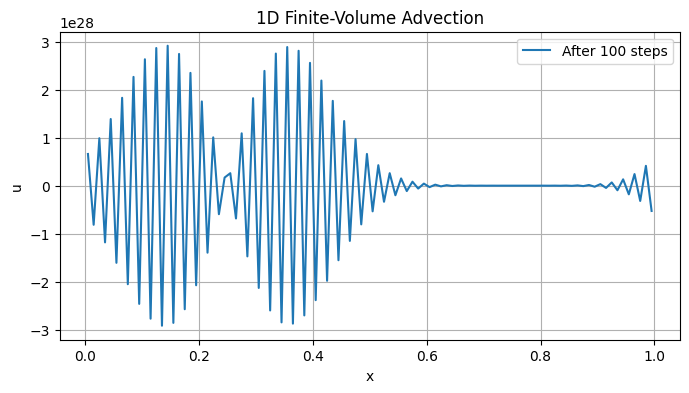

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
nx = 100                # number of cells
x_start, x_end = 0, 1   # domain
a = 1.0                 # advection speed
cfl = 0.5               # CFL number
dx = (x_end - x_start) / nx
dt = cfl * dx / a       # time step from CFL
nt = 100                # number of time steps

# Grid and initial condition
x = np.linspace(x_start + 0.5*dx, x_end - 0.5*dx, nx)  # cell centers
u = np.where((x >= 0.4) & (x <= 0.6), 1.0, 0.0)         # square pulse

def compute_flux(u, a):
    """Upwind numerical flux."""
    flux = np.zeros_like(u)
    flux[1:] = a * u[:-1]
    flux[0] = a * u[-1]  # periodic BC
    return flux

# Time integration loop
for n in range(nt):
    flux = compute_flux(u, a)
    u -= dt / dx * (flux - np.roll(flux, 1))  # flux difference

# Plot results
plt.figure(figsize=(8, 4))
plt.plot(x, u, label='After {} steps'.format(nt))
plt.title('1D Finite-Volume Advection')
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.legend()
plt.show()


backwards eulers

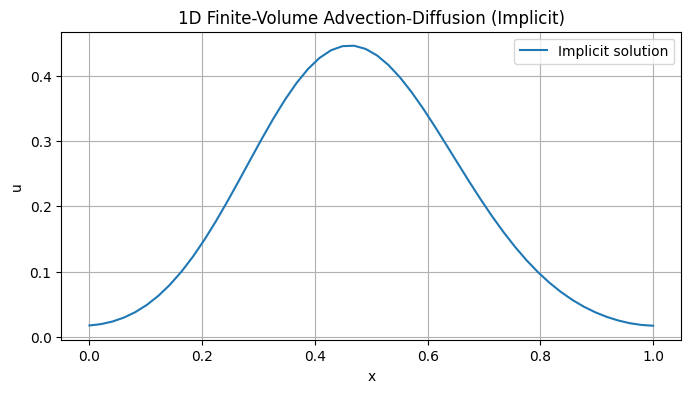

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Parameters
nx = 50
x_start, x_end = 0.0, 1.0
x = np.linspace(x_start, x_end, nx)
dx = (x_end - x_start) / (nx - 1)
a = 1.0     # advection speed
nu = 0.01   # diffusion coefficient
dt = 0.01
nt = 100    # number of time steps

# Initial condition: square pulse
u = np.where((x >= 0.4) & (x <= 0.6), 1.0, 0.0)

# Helper: assemble Jacobian matrix (implicit FV discretization)
def build_jacobian(nx, dx, dt, a, nu):
    alpha = nu * dt / dx**2
    beta = a * dt / (2 * dx)

    main_diag = (1 + 2*alpha) * np.ones(nx)
    off_diag1 = (-alpha - beta) * np.ones(nx - 1)
    off_diag2 = (-alpha + beta) * np.ones(nx - 1)

    # Periodic BCs
    diagonals = [main_diag, off_diag1, off_diag2]
    offsets = [0, -1, 1]
    J = diags(diagonals, offsets, shape=(nx, nx), format='csr')

    # Periodic wrap around terms
    J = J.tolil()
    J[0, -1] = -alpha - beta
    J[-1, 0] = -alpha + beta
    return J.tocsr()

# Time stepping
for n in range(nt):
    J = build_jacobian(nx, dx, dt, a, nu)
    u = spsolve(J, u)

# Plot final result
plt.figure(figsize=(8, 4))
plt.plot(x, u, label='Implicit solution')
plt.title('1D Finite-Volume Advection-Diffusion (Implicit)')
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.legend()
plt.show()


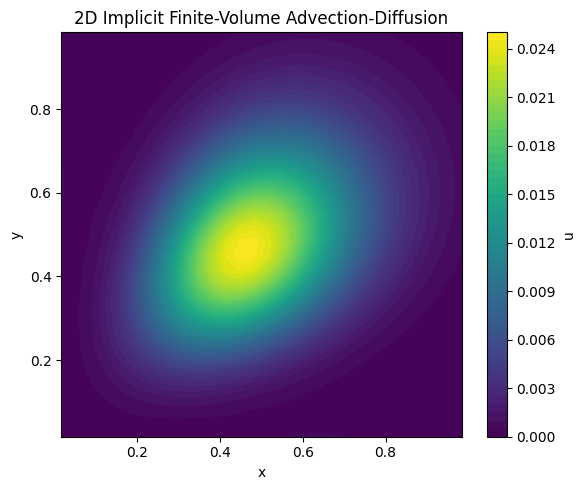

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

# Grid parameters
nx, ny = 30, 30
Lx, Ly = 1.0, 1.0
dx, dy = Lx / nx, Ly / ny
x = np.linspace(dx/2, Lx - dx/2, nx)
y = np.linspace(dy/2, Ly - dy/2, ny)
X, Y = np.meshgrid(x, y, indexing='ij')

# Physical parameters
a, b = 1.0, 1.0       # advection speeds
nu = 0.01             # diffusion coefficient
dt = 0.01
nt = 100              # number of time steps

# Initial condition: circular pulse
u = np.where((X - 0.5)**2 + (Y - 0.5)**2 < 0.05**2, 1.0, 0.0)
u = u.reshape(-1)  # flatten to 1D for solving

# Helper: index in flat array
def idx(i, j):
    return i * ny + j

# Build sparse Jacobian matrix
def build_jacobian(nx, ny, dx, dy, dt, a, b, nu):
    N = nx * ny
    J = lil_matrix((N, N))

    ax = a * dt / (2 * dx)
    ay = b * dt / (2 * dy)
    dx2 = nu * dt / dx**2
    dy2 = nu * dt / dy**2

    for i in range(nx):
        for j in range(ny):
            p = idx(i, j)
            J[p, p] = 1 + 2 * (dx2 + dy2)

            # Periodic boundary indices
            ip = (i + 1) % nx
            im = (i - 1) % nx
            jp = (j + 1) % ny
            jm = (j - 1) % ny

            J[p, idx(im, j)] = -dx2 - ax
            J[p, idx(ip, j)] = -dx2 + ax
            J[p, idx(i, jm)] = -dy2 - ay
            J[p, idx(i, jp)] = -dy2 + ay

    return J.tocsr()

# Time-stepping loop
for n in range(nt):
    J = build_jacobian(nx, ny, dx, dy, dt, a, b, nu)
    u = spsolve(J, u)

# Reshape and plot final result
u_final = u.reshape((nx, ny))

plt.figure(figsize=(6, 5))
plt.contourf(X, Y, u_final, levels=50)
plt.colorbar(label='u')
plt.title('2D Implicit Finite-Volume Advection-Diffusion')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()


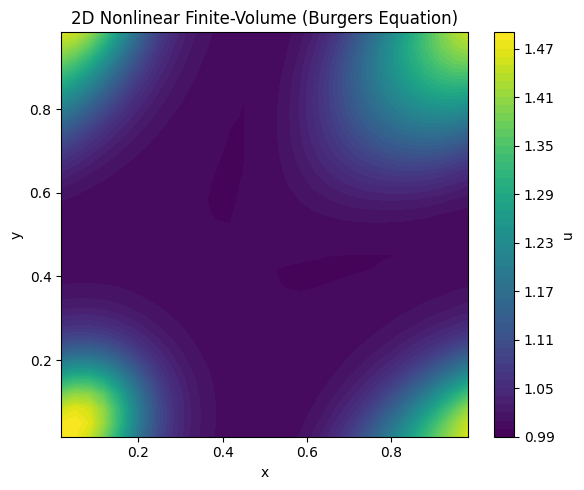

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

# Grid
nx, ny = 30, 30
Lx, Ly = 1.0, 1.0
dx, dy = Lx / nx, Ly / ny
x = np.linspace(dx/2, Lx - dx/2, nx)
y = np.linspace(dy/2, Ly - dy/2, ny)
X, Y = np.meshgrid(x, y, indexing='ij')

# Time and physics
dt = 0.01
nt = 50
nu = 0.01

# Initial conditions
u = np.ones((nx, ny))
v = np.ones((nx, ny))
u[int(nx/4):int(nx/2), int(ny/4):int(ny/2)] = 2.0
v[int(nx/4):int(nx/2), int(ny/4):int(ny/2)] = 2.0

def idx(i, j, var):
    """Map 2D + var index to 1D index."""
    return (i * ny + j) * 2 + var  # var=0 for u, 1 for v

def flatten_uv(u, v):
    return np.vstack([u.ravel(), v.ravel()]).T.ravel()

def unflatten_uv(U):
    U = U.reshape((-1, 2))
    u = U[:, 0].reshape((nx, ny))
    v = U[:, 1].reshape((nx, ny))
    return u, v

# Newton solver
def nonlinear_step(u_old, v_old, dt, dx, dy, nu, max_iter=10, tol=1e-6):
    U = flatten_uv(u_old, v_old)

    for k in range(max_iter):
        u, v = unflatten_uv(U)
        R = np.zeros_like(U)
        J = lil_matrix((U.size, U.size))

        for i in range(nx):
            for j in range(ny):
                ip, im = (i + 1) % nx, (i - 1) % nx
                jp, jm = (j + 1) % ny, (j - 1) % ny

                # Local values
                uij, vij = u[i, j], v[i, j]
                u_x = (u[ip, j] - u[im, j]) / (2 * dx)
                u_y = (u[i, jp] - u[i, jm]) / (2 * dy)
                v_x = (v[ip, j] - v[im, j]) / (2 * dx)
                v_y = (v[i, jp] - v[i, jm]) / (2 * dy)

                lap_u = (u[ip, j] - 2*uij + u[im, j]) / dx**2 + (u[i, jp] - 2*uij + u[i, jm]) / dy**2
                lap_v = (v[ip, j] - 2*vij + v[im, j]) / dx**2 + (v[i, jp] - 2*vij + v[i, jm]) / dy**2

                ru = (uij - u_old[i, j]) / dt + uij * u_x + vij * u_y - nu * lap_u
                rv = (vij - v_old[i, j]) / dt + uij * v_x + vij * v_y - nu * lap_v

                pi_u = idx(i, j, 0)
                pi_v = idx(i, j, 1)
                R[pi_u] = ru
                R[pi_v] = rv

                # Approximate Jacobian (diagonal-only for demo)
                J[pi_u, pi_u] = 1/dt + u_x + uij/dx + vij/dy + 4*nu/dx**2
                J[pi_v, pi_v] = 1/dt + v_y + uij/dx + vij/dy + 4*nu/dx**2

        delta = spsolve(J.tocsr(), -R)
        U += delta

        if np.linalg.norm(delta, ord=np.inf) < tol:
            break

    return unflatten_uv(U)

# Time loop
for n in range(nt):
    u, v = nonlinear_step(u, v, dt, dx, dy, nu)

# Plot
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, u, levels=50)
plt.colorbar(label='u')
plt.title('2D Nonlinear Finite-Volume (Burgers Equation)')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()


In [6]:
def build_jacobian_4th(nx, ny, dx, dy, dt, a, b, nu):
    N = nx * ny
    J = lil_matrix((N, N))

    # 4th-order coefficients
    alpha_x = nu * dt / (12 * dx**2)
    alpha_y = nu * dt / (12 * dy**2)
    beta_x = a * dt / (12 * dx)
    beta_y = b * dt / (12 * dy)

    for i in range(nx):
        for j in range(ny):
            p = idx(i, j)

            # Periodic indices
            im2 = (i - 2) % nx
            im1 = (i - 1) % nx
            ip1 = (i + 1) % nx
            ip2 = (i + 2) % nx

            jm2 = (j - 2) % ny
            jm1 = (j - 1) % ny
            jp1 = (j + 1) % ny
            jp2 = (j + 2) % ny

            # Center term
            J[p, idx(i, j)] = 1 + 30 * (alpha_x + alpha_y)

            # X-direction
            J[p, idx(im2, j)] = alpha_x + beta_x
            J[p, idx(im1, j)] = -16 * alpha_x + 8 * beta_x
            J[p, idx(ip1, j)] = -16 * alpha_x - 8 * beta_x
            J[p, idx(ip2, j)] = alpha_x - beta_x

            # Y-direction
            J[p, idx(i, jm2)] = alpha_y + beta_y
            J[p, idx(i, jm1)] = -16 * alpha_y + 8 * beta_y
            J[p, idx(i, jp1)] = -16 * alpha_y - 8 * beta_y
            J[p, idx(i, jp2)] = alpha_y - beta_y

    return J.tocsr()


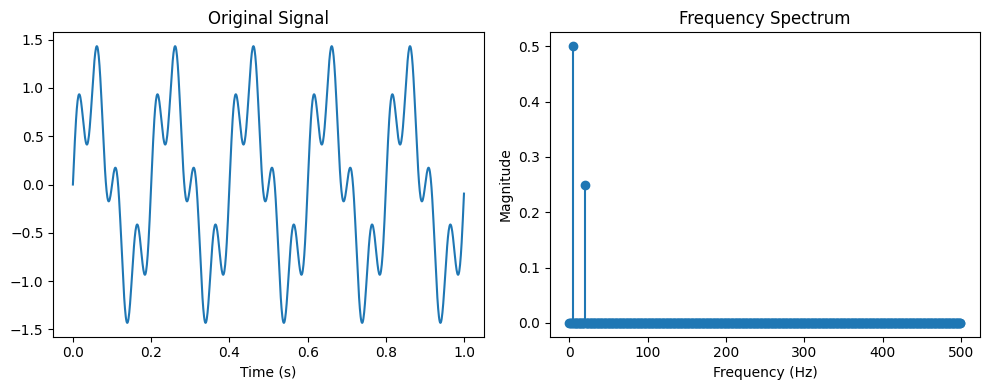

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Time domain signal
t = np.linspace(0, 1, 1000, endpoint=False)
f = 5  # frequency 1 in Hz
g = 20 # frequency 2 in Hz
signal = np.sin(2 * np.pi * f * t) + 0.5 * np.sin(2 * np.pi * g * t)

# Fourier Transform
freqs = np.fft.fftfreq(len(t), d=t[1]-t[0])  # frequency bins
fft_result = np.fft.fft(signal)
magnitude = np.abs(fft_result) / len(t)

# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(t, signal)
plt.title("Original Signal")
plt.xlabel("Time (s)")

plt.subplot(1, 2, 2)
plt.stem(freqs[:len(t)//2], magnitude[:len(t)//2], basefmt=" ")
plt.title("Frequency Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.tight_layout()
plt.show()


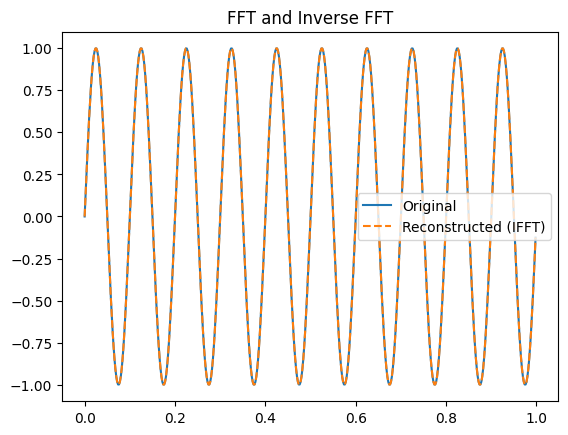

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define a signal in real space
x = np.linspace(0, 1, 500, endpoint=False)
signal = np.sin(2 * np.pi * 10 * x)

# FFT -> Frequency domain
fft_signal = np.fft.fft(signal)

# Inverse FFT -> Back to real space
reconstructed = np.fft.ifft(fft_signal)

# Plot
plt.plot(x, signal, label='Original')
plt.plot(x, reconstructed.real, '--', label='Reconstructed (IFFT)')
plt.legend()
plt.title("FFT and Inverse FFT")
plt.show()
